Pronóstico Adaptativo
===

**Juan David Velásquez Henao**  
jdvelasq@unal.edu.co   
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia

---

Haga click [aquí](https://github.com/jdvelasq/deep-neural-nets/tree/master/) para acceder al repositorio online.

Haga click [aquí](http://nbviewer.jupyter.org/github/jdvelasq/deep-neural-nets/tree/master/) para explorar el repositorio usando `nbviewer`. 

---

# Definición del problema

Hay un sistema que emite una señal $d(t)$ contaminada con ruido, cuyas características pueden cambiar en el tiempo. Una muestra de una señal característica se presenta en la gráfica de abajo. Para efectos de control, se requiere un sistema que pronostique el valor actual de la señal, $d(t)$, con base en sus valores pasados $d(t-1)$, $d(t-2)$, ... 


Para facilitar el problema, a continuación se genera la señal $d(t)$.

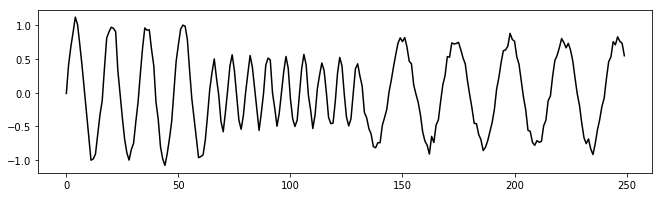

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

np.random.seed(12345)
d =  [1.0 * math.sin(t * math.pi /  8) for t in range(64)]
d += [0.5 * math.sin(t * math.pi /  4) for t in range(64, 134)]
d += [0.8 * math.sin(t * math.pi / 12) for t in range(134, 250)]
d =  [x + 0.06 * np.random.standard_normal() for x in d]

plt.figure(figsize=(11,3))
plt.plot(d, color='black');

# Metodología de Solución

El modelo que se presenta a continuación representa un perceptrón bipolar (con salida $\in \{-1, +1\}$) con entradas y pesos reales, el cual puede ser representado como:


![alt](images/AdalinePronostico-02.png)

donde la entrada neta se calcula como:

$$v = w_0 + \sum_{i=1}^n w_i x_i = \mathbf{w}^T \mathbf{x}$$

con $\mathbf{w} = [w_0, ..., w_n]^T$ y $\mathbf{x} = [+1, x_1, x_2, ..., x_n]^T$. La regla de activación es:

$$\varphi(v) = 
\begin{cases}      
      +1, & \text{Si $v \ge 0$}\\
      -1, & \text{Si $v \lt 0$}\\
\end{cases}$$

Este tipo de perceptrón puede ser utilizado para representar funciones lógicas bipolares:

![alt](images/AdalinePronostico-03.png)

---
**Ejercicio.--**  Especifique pesos que permitan representar las siguientes funciones:

![alt](images/AdalinePronostico-04.png)

---

### Combinador lineal adaptativo

La primera parte del perceptrón bipolar corresponde a un combinador lineal adaptativo (ADALINE), mientras que la función de activación es un conmutador bipolar.

![alt](images/AdalinePronostico-05.png)

El combinador lineal adaptativo puede:


* Adaptarse automáticamente a ambientes dinámicos (¿auto-optimización?).


* Realizar tareas de filtrado, pronóstico y toma de decisiones .


* Eextrapolar el comportamiento de un sistema con el fin de manejar nuevas situaciones.


* Reproducir el comportamiento de sistemas no lineales con parámetros cambiantes en el tiempo.

Un ADALINE es un sistema adaptativo de lazo cerrado. Los sistemas de *lazo abierto* se basan en el siguiente procedimiento:

* Medida de la información de entrada al sistema.


* Alicación de una fórmula o algoritmo.


* Aplicación del resultado para ajustar el sistema adaptativo (La adaptación no depende explícitamente de las propiedades de la salida).


En los sistemas de lazo cerrado:

* Experimentación automática ajustado el sistema adaptativo.


* Comparación entre el resultado deseado y la salida del sistema adaptativo para modificar los ajustes.


En el caso del problema planteado, el pronóstico se realiza usando el siguiente sistema adaptativo de lazo cerrado, en el cual, el modelo adaptativo es un ADALINE.

![alt](images/AdalinePronostico-06.png)

### Estimación de los pesos del ADALINE usando $\mu$-LMS

Se definen dos tipos de errores:


* Error lineal:

$$e(k)=d(k)-y(k)=d(k)-\mathbf{w}^T (k) \mathbf{x}(k)=d(k)-\mathbf{x}^T(k)\mathbf{w}(k)$$


* Error cuadrático:


$$e^2 (k)=d^2 (k)+\mathbf{x}^T (k)\mathbf{w}(k) \mathbf{w}^T (k) \mathbf{x}(k)-2d(k) \mathbf{x}^T (k)\mathbf{w}(k)$$

La estimación de los pesos puede hacerse mediante el método del gradiente descendente o Algoritmo $\mu$-LMS. En este caso, la función de error se define como $e^2_l(k)$, cuyo gradiente es:

$$\nabla \left(e^2_l(k) \right) = 
\frac{\partial e^2_l(k)}{\partial \mathbf{w} (k)} =
\begin{bmatrix} 
  \frac{\partial e^2_l(k)}{\partial w_0 (k)}
  \\ \vdots \\ 
  \frac{\partial e^2_l(k)}{\partial w_n (k)}
 \end{bmatrix} 
$$

---
**Ejercicio.--** Explique la fórmula anterior.

---

Entonces:

$$
\mathbf{w}(k+1) = 
\mathbf{w}(k) - \mu \frac{\partial e^2_l(k)}{\partial \mathbf{w} (k)}  = 
\mathbf{w}(k) + 2 \mu e_l(k) \mathbf{x}(k) 
$$

El algoritimo converge si:

$$
0 < \mu < \frac{1}{1 + \sum_{i=0}^n E[x_i^2]}
$$

### Solución al problema propuesto usando  `numpy`.

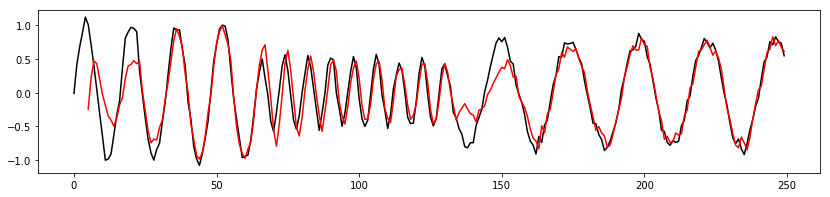

In [6]:
## mu es la tasa de aprendizaje (escogida arbitrariamente)
mu = 0.05

## Para pronosticar el valor actual se toman los `L` 
## valores previos de la serie
L = 5

## Los pesos iniciales del ADALINE son 
## fijados arbitrariamente
## w es un vector columna
w = np.array(0.1 * np.random.standard_normal(L+1)).reshape(L+1, 1)


y_pred = np.zeros(len(d))
y_pred[0:L] = np.nan
for t in range(L, len(d)):
    x = np.array([1] + d[t-L:t]) ## entrada al ADALINE
    x = x.reshape(len(x), 1)
    p = w.T @ x                  ## pronostico
    y_pred[t] = p
    
    ## algoritmo de aprendizaje
    e = d[t] - p
    w = w + 2 * mu * e * x

plt.figure(figsize=(14,3))
plt.plot(d, color='black');
plt.plot(y_pred, color = 'red');


---
**Ejercicio.--** Los valores de $\mu$ y $L$ fueron escogidos arbitrariamente. Cómo podría obtener sus valores óptimos?.

---

### Estimación de los pesos del ADALINE usando $\alpha$-LMS o Regla Delta

El entrenamiento también puede hacerse mediante el algoritmo $\alpha$-LMS o Regla Delta de Widrow-Hoff:

(1) Error lineal: $e_l(k) = d(k) - \mathbf{w}^T(k) \mathbf{x}(k)$


(2) Por definición: $e_l(k+1) = d(k) - \mathbf{w}^T (k+1) \mathbf{x}(k)$ sin cambiar el patrón.


(3) $\Delta e_l(k) = e_l (k+1)-e_l (k)= \mathbf{w}^T (k)  \mathbf{x}(k) - \mathbf{w}^T (k+1)  \mathbf{x}(k)=
- \mathbf{x}^T (k)  \Delta \mathbf{w}(k)$


(4) Se debe garantizar que $e_l (k)$ converge asintóticamente a cero.


(5) Un supuesto podría ser: $e_l (k+1)=(1-\alpha)  e_l (k)$   o   $\Delta e_l (k)=- \alpha e_l (k)$


(6) Haciendo (3)=(5):  $ -\mathbf{x}^T (k) \Delta \mathbf{w}(k)=-\alpha e_l (k)$


(7) Multiplicando (6) por $\mathbf{x}(k)$: $- \Delta \mathbf{w}(k)[\mathbf{x}^T (k)  \mathbf{x}(k)] = -\alpha e_l (k) \mathbf{x}(k)$


(8) Despejando:

$$
\mathbf{w}(k+1) = \mathbf{w}(k) + \alpha \frac{e_l (k)  \mathbf{x}(k)}{|\mathbf{x}(k)|^2} 
$$

---
**Ejercicio.--** Solucione el problema propuesto usando la regla delta y `numpy`.

---

**Ejercicio.--** Escriba una función que reciba como entradas: la cantidad de retardos $L$, la tasa de aprendizaje $\alpha$, y la serie $d$. La función debe retornar el vector de pronosticos. La función debe ser implementada internamente usando `TensorFlow`.

---

Pronóstico Adaptativo
===

**Juan David Velásquez Henao**  
jdvelasq@unal.edu.co   
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia

---

Haga click [aquí](https://github.com/jdvelasq/deep-neural-nets/tree/master/) para acceder al repositorio online.

Haga click [aquí](http://nbviewer.jupyter.org/github/jdvelasq/deep-neural-nets/tree/master/) para explorar el repositorio usando `nbviewer`. 